## LB
### 1.022
### 1.019 (clip item_cnt_day to [0,20] before feature engineering)



In [17]:
import os
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn import model_selection

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from itertools import product # to expand month-shop-item combo

import pickle

import gc
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [2]:
def rmse_clip(y_true, y_pred):
    y_pred = y_pred.clip(0,20)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return(rmse)

In [9]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64" or df[c].dtype == "int32"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

### Read in Data

In [4]:
train = pd.read_csv(r'../data/sales_train.csv.gz')
train.shape

(2935849, 6)

In [5]:
train[:3]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


#### Read in item categories

In [6]:
items0 = pd.read_csv(r'../data2/item_category2.csv')
# shops0 = pd.read_csv(r'../data/shops.csv')
# item_cat0 = pd.read_csv(r'../data/item_categories.csv')
items0 = downcast_dtypes(items0)
items0[:3]# ok contains name of the item/cat/shop; ABBYY FineReader??

,item_id,item_category_id,item_category_id1,item_category_id2,item_category_id3,sys,product,cat1,cat2,cat3,cat1_prob,cat2_prob,cat3_prob,item_category_id2.1
0,0,40,40-16,40-23,40-10,dvd,cinema,16.0,23.0,10.0,0.520833,0.020833,0.020833,40-23
1,1,76,76-0,76-0,76-0,pc,programs,0.0,0.0,0.0,1.000000,0.000000,0.000000,76-0
2,2,40,40-23,40-22,40-1,dvd,cinema,23.0,22.0,1.0,0.041667,0.041667,0.041667,40-22


In [7]:
train[(train.shop_id==25)&(train.item_id==2552)]  
# looks like return. looks like negative rows should be removed
# Or make a "returned?" feature

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [8]:
(train['item_cnt_day']==0).sum()

0

In [10]:
train2 = downcast_dtypes(train[train.item_cnt_day>0])
# train2 = train[(train.item_cnt_day>0) & train.shop_id.isin(test.shop_id.unique())]

print(train2.shape)

train2['date2'] = pd.to_datetime(train2['date'],format='%d.%m.%Y')
train2.drop(labels='date',axis=1,inplace=True)

# print(train2.shop_id.nunique())
# pickle.dump(train2,open(r'../data2/train_42shops.pkl','wb'))
del train

(2928493, 6)


### Make features for linear model
#### 1. Expand the month/shop/item grid

In [11]:
shops_in_tr = train2.shop_id.unique()
items_in_tr = train2.item_id.unique()
months_in_tr =train2.date_block_num.unique()
print(len(shops_in_tr),len(items_in_tr),len(months_in_tr))

grid = np.array(list(product(*[shops_in_tr,items_in_tr,months_in_tr])),dtype='int32')

grid = pd.DataFrame(grid,columns=['shop_id','item_id','date_block_num'],dtype='int32')
grid[:3]

60 21804 34


,shop_id,item_id,date_block_num
0,59,22154,0
1,59,22154,1
2,59,22154,2


In [12]:
del shops_in_tr
del items_in_tr
del months_in_tr

#### 2. Aggregate sales by month

In [13]:
train2 = pd.merge(train2, items0[['item_id','item_category_id','sys',
                                  'item_category_id1','item_category_id2','item_category_id3',
                                  'cat1_prob','cat2_prob','cat3_prob']],how='left')
train2[:3]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date2,item_category_id,sys,item_category_id1,item_category_id2,item_category_id3,cat1_prob,cat2_prob,cat3_prob
0,0,59,22154,999.000000,1.0,2013-01-02,37,blu-ray,37-9,37-15,37-21,0.617850,0.016615,0.016615
1,0,25,2552,899.000000,1.0,2013-01-03,58,other,58-1,58-6,58-8,0.723831,0.018411,0.018411
2,0,25,2554,1709.050049,1.0,2013-01-06,58,other,58-1,58-0,58-6,0.441094,0.258686,0.021444


##### 2.1 Clipping daily sales item_cnt_day

In [14]:
train2.item_cnt_day.describe()

count    2.928493e+06
mean     1.248337e+00
std      2.612679e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

In [15]:
np.percentile(train2.item_cnt_day,99.5) 

8.0

In [16]:
train2.loc[:,'item_cnt_day'] = train2.item_cnt_day.clip(0,20)

##### 2.2 Aggregate sales by month

In [ ]:
# monthly sales by shop-item
train2.sort_values(by=['date_block_num','shop_id','item_id','date2'],inplace=True)
temp = train2.groupby(['date_block_num','shop_id','item_id'],as_index=False)\
    .agg({'item_cnt_day':{'shop_item_cnt':'sum'}})

temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]

monthly_sales_all = pd.merge(grid, temp, how='left',on=['date_block_num','shop_id','item_id']).fillna(0)


# monthly sales by shop
temp = train2.groupby(['date_block_num','shop_id'],as_index=False).agg({'item_cnt_day':{'shop_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]

monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','shop_id']).fillna(0)


# monthly sales by item
temp = train2.groupby(['date_block_num','item_id'],as_index=False).agg({'item_cnt_day':{'item_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]

monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','item_id']).fillna(0)

In [ ]:
# monthly sales by cat/sys
# first, get item_category_id1 of each item on the LHS
monthly_sales_all = pd.merge(monthly_sales_all,items0[['item_id','item_category_id','sys',
                                                       'item_category_id1','item_category_id2','item_category_id3',
                                                       'cat1_prob','cat2_prob','cat3_prob']],
                             how='left',on='item_id')
# by sys
temp = train2.groupby(['date_block_num','sys'],as_index=False).agg({'item_cnt_day':{'sys_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]
monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','sys']).fillna(0)

# by cat
temp = train2.groupby(['date_block_num','item_category_id'],as_index=False).agg({'item_cnt_day':{'cat_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]
monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','item_category_id']).fillna(0)

In [ ]:
monthly_sales_all[:3]

In [18]:
#  monthly sales by finer cat (created from LDA)
temp = train2.groupby(['date_block_num','item_category_id1'],as_index=False).agg({'item_cnt_day':{'cat1_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]
monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','item_category_id1']).fillna(0)

temp = train2.groupby(['date_block_num','item_category_id2'],as_index=False).agg({'item_cnt_day':{'cat2_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]
monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','item_category_id2']).fillna(0)

temp = train2.groupby(['date_block_num','item_category_id3'],as_index=False).agg({'item_cnt_day':{'cat3_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]
monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','item_category_id3']).fillna(0)

# downcast types to save memory
monthly_sales_all=downcast_dtypes(monthly_sales_all)
print(monthly_sales_all.shape)
monthly_sales_all[:3]

(44480160, 15)


,shop_id,item_id,date_block_num,shop_item_cnt,shop_cnt,item_cnt,item_category_id1,item_category_id2,item_category_id3,cat1_prob,cat2_prob,cat3_prob,cat1_cnt,cat2_cnt,cat3_cnt
0,59,22154,0,1.0,2026.0,18.0,37-9,37-15,37-21,0.61785,0.016615,0.016615,113.0,2873.0,361.0
1,59,22154,1,0.0,1906.0,6.0,37-9,37-15,37-21,0.61785,0.016615,0.016615,303.0,3793.0,522.0
2,59,22154,2,0.0,2032.0,2.0,37-9,37-15,37-21,0.61785,0.016615,0.016615,218.0,2823.0,398.0


In [23]:
scaler = StandardScaler()
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
monthly_sales_all['cat_cnt'] = monthly_sales_all.cat1_cnt * monthly_sales_all.cat1_prob + \
                               monthly_sales_all.cat2_cnt * monthly_sales_all.cat2_prob + \
                               monthly_sales_all.cat3_cnt * monthly_sales_all.cat3_prob

In [20]:
to_drop = [col for col in monthly_sales_all.columns if re.search(re.compile('item_category_id|_prob|cat[0-9]'), col) is not None]
monthly_sales_all.drop(labels=to_drop,axis=1,inplace=True)

In [21]:
del grid
del train2
del temp

##### Append block 34

In [22]:
test_block = monthly_sales_all.loc[monthly_sales_all.date_block_num==33,['shop_id','item_id','date_block_num']]
test_block.loc[:,'date_block_num'] += 1
print(test_block.date_block_num.unique())
test_block[:3]

[34]


,shop_id,item_id,date_block_num
33,59,22154,34
67,59,2552,34
101,59,2554,34


In [23]:
monthly_sales_all = pd.concat([monthly_sales_all,test_block],ignore_index=True).fillna(0)

In [24]:
print(monthly_sales_all.shape)
monthly_sales_all[:3]

(45788400, 7)


,cat_cnt,date_block_num,item_cnt,item_id,shop_cnt,shop_id,shop_item_cnt
0,123.550667,0,18.0,22154,2026.0,59,1.0
1,258.903198,1,6.0,22154,1906.0,59,0.0
2,188.208893,2,2.0,22154,2032.0,59,0.0


In [25]:
del test_block

### Start building features

#### Set up time-based features

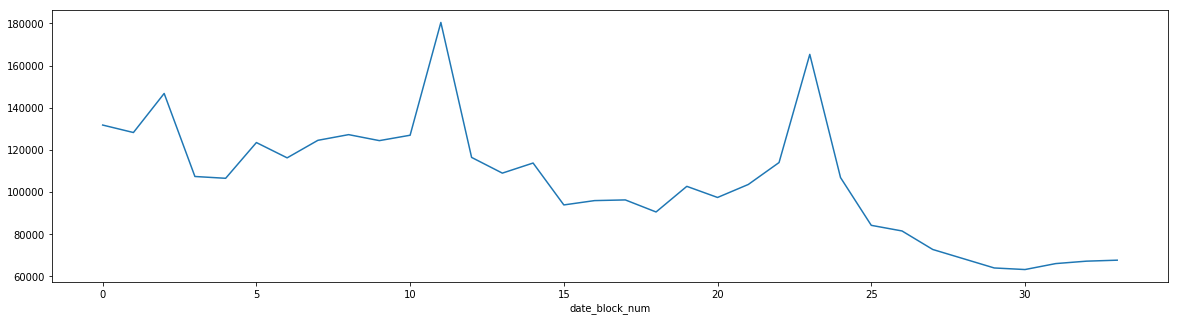

In [26]:
# Clear seasonality - spike in Dec; March
# Also a clear downward sloping trend
plt.figure(figsize=(20,5))
monthly_sales_all[monthly_sales_all.date_block_num<34].groupby(['date_block_num'])['shop_item_cnt'].sum().plot() 

In [27]:
monthly_sales_all[monthly_sales_all.date_block_num<34]['shop_item_cnt'].describe()  # max is changed to 600

count    4.448016e+07
mean     8.053334e-02
std      1.284516e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.180000e+02
Name: shop_item_cnt, dtype: float64

In [29]:
np.percentile(monthly_sales_all[monthly_sales_all.date_block_num<34]['shop_item_cnt'],99.5)

3.0

<strong>Since we have lag features, we are just going to build the features on entire monthly_sales data w/o spliting monthly_sales and X_val. 
    
However, make sure we do feature selection only on the monthly_sales portion (where date_block_num < hold_out_month) </strong>

In [28]:
index_cols = ['shop_id','item_id','date_block_num']
cols_to_rename = list(monthly_sales_all.columns.difference(index_cols)) # all columns except these four
shift_range = [1,2,3,4,5,12]
cols_to_rename

['cat_cnt', 'item_cnt', 'shop_cnt', 'shop_item_cnt']

In [29]:
gc.collect()

124

In [30]:
for month_shift in tqdm_notebook(shift_range):
    
    """Take the entire data set, add 1 to date_block_num, and rename the columns that we want to create a lag for"""
    
    train_shift = monthly_sales_all[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    monthly_sales_all = pd.merge(monthly_sales_all, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

In [31]:
monthly_sales_all['month'] = (np.mod(monthly_sales_all.date_block_num,12)+1).astype('int8')

In [32]:
%%time
monthly_sales_all.to_hdf(r'../data2/monthly_sales_all_shop_item_w_lag_cat_top3_avg.h5','monthly_sales_all')

Wall time: 59 s


In [78]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/monthly_sales_all_shop_item_w_lag_cat_top3_avg.h5','monthly_sales_all')

Wall time: 4.36 s


In [79]:
monthly_sales_all = monthly_sales_all[(monthly_sales_all.date_block_num>=12) & (monthly_sales_all.date_block_num<34)]

In [34]:
monthly_sales_all[:3]

,cat_cnt,date_block_num,item_cnt,item_id,shop_cnt,shop_id,shop_item_cnt,cat_cnt_lag_1,item_cnt_lag_1,shop_cnt_lag_1,...,shop_item_cnt_lag_4,cat_cnt_lag_5,item_cnt_lag_5,shop_cnt_lag_5,shop_item_cnt_lag_5,cat_cnt_lag_12,item_cnt_lag_12,shop_cnt_lag_12,shop_item_cnt_lag_12,month
12,190.784729,12,0.0,22154,1500.0,59,0.0,224.190857,1.0,2398.0,...,0.0,165.945160,2.0,2054.0,0.0,123.550667,18.0,2026.0,1.0,1
13,213.054642,13,0.0,22154,1428.0,59,0.0,190.784729,0.0,1500.0,...,0.0,376.901642,1.0,1985.0,0.0,258.903198,6.0,1906.0,0.0,2
14,141.346558,14,0.0,22154,1475.0,59,0.0,213.054642,0.0,1428.0,...,0.0,178.945877,3.0,1747.0,0.0,188.208893,2.0,2032.0,0.0,3


In [30]:
# # List of all lagged features
# fit_cols = [col for col in monthly_sales_all.columns if col[-1] in [str(item) for item in shift_range]] 
# # We will drop these at fitting stage
# to_drop_cols = list(set(list(monthly_sales_all.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 
# to_drop_cols

- <strong>One-hot encode month</strong>

In [35]:
enc = OneHotEncoder()

In [36]:
enc.fit_transform(pd.DataFrame(list(range(1,13)))).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [37]:
m_onehot = enc.fit_transform(pd.DataFrame(list(range(1,13)))).toarray()
m_onehot.shape
# 12 levels -> 12 features, need to drop 1 to avoid multicolinearity (since we are first going to fit a linear model)

# reshape(-1,1) -1 means unknown dimension which we just let numpy to figure out
# since OneHotEncoder() takes 2-D array, we need to make our 1D series into a 2-D matrix format
# we know there is one column, and let numpy to figure out how many rows there should be
# <=> reshape.(rows_in_your_data,1)

(12, 12)

In [38]:
m_onehot_df = pd.DataFrame(np.hstack((np.array(range(1,13)).reshape(12,1),m_onehot[:,1:])), columns=['month']+['m'+str(i) for i in range(2,13)], dtype='int8')
m_onehot_df

,month,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,0,0,0,0,0,0,0
3,4,0,0,1,0,0,0,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,0,0,0
5,6,0,0,0,0,1,0,0,0,0,0,0
6,7,0,0,0,0,0,1,0,0,0,0,0
7,8,0,0,0,0,0,0,1,0,0,0,0
8,9,0,0,0,0,0,0,0,1,0,0,0
9,10,0,0,0,0,0,0,0,0,1,0,0


In [39]:
monthly_sales_all = pd.merge(monthly_sales_all,m_onehot_df,how='left',on='month').drop(labels=['month'],axis=1)
monthly_sales_all[:3]

,cat_cnt,date_block_num,item_cnt,item_id,shop_cnt,shop_id,shop_item_cnt,cat_cnt_lag_1,item_cnt_lag_1,shop_cnt_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,190.784729,12,0.0,22154,1500.0,59,0.0,224.190857,1.0,2398.0,...,0,0,0,0,0,0,0,0,0,0
1,213.054642,13,0.0,22154,1428.0,59,0.0,190.784729,0.0,1500.0,...,0,0,0,0,0,0,0,0,0,0
2,141.346558,14,0.0,22154,1475.0,59,0.0,213.054642,0.0,1428.0,...,1,0,0,0,0,0,0,0,0,0


In [40]:
monthly_sales_all = downcast_dtypes(monthly_sales_all)
monthly_sales_all.dtypes

cat_cnt                 float32
date_block_num            int32
item_cnt                float32
item_id                   int32
shop_cnt                float32
shop_id                   int32
shop_item_cnt           float32
cat_cnt_lag_1           float32
item_cnt_lag_1          float32
shop_cnt_lag_1          float32
shop_item_cnt_lag_1     float32
cat_cnt_lag_2           float32
item_cnt_lag_2          float32
shop_cnt_lag_2          float32
shop_item_cnt_lag_2     float32
cat_cnt_lag_3           float32
item_cnt_lag_3          float32
shop_cnt_lag_3          float32
shop_item_cnt_lag_3     float32
cat_cnt_lag_4           float32
item_cnt_lag_4          float32
shop_cnt_lag_4          float32
shop_item_cnt_lag_4     float32
cat_cnt_lag_5           float32
item_cnt_lag_5          float32
shop_cnt_lag_5          float32
shop_item_cnt_lag_5     float32
cat_cnt_lag_12          float32
item_cnt_lag_12         float32
shop_cnt_lag_12         float32
shop_item_cnt_lag_12    float32
m2      

#### Predict w lag v RF w lag

In [80]:
hold_out_month = 33
val_month = 32

In [81]:
feats = ['shop_item_cnt_lag_1']

In [82]:
hold_out_df = monthly_sales_all.loc[monthly_sales_all.date_block_num == hold_out_month,
                            ['shop_id','item_id','shop_item_cnt']+feats]
val = monthly_sales_all.loc[monthly_sales_all.date_block_num == val_month,
                            ['shop_id','item_id','shop_item_cnt']+feats]
val[:3]

,shop_id,item_id,shop_item_cnt,shop_item_cnt_lag_1
32,59,22154,0.0,0.0
66,59,2552,0.0,0.0
100,59,2554,0.0,0.0


#### Benchmark - on val and hold-out

In [83]:
print('Hold out BC (month 33):')
print(rmse_clip(y_true = hold_out_df.loc[hold_out_df.shop_item_cnt>0,'shop_item_cnt'],y_pred = hold_out_df.loc[hold_out_df.shop_item_cnt>0,'shop_item_cnt_lag_1']))

Hold out BC (month 33):
5.868762337018616


In [84]:
print('Val BC (month 32)')
print(rmse_clip(y_true = val.loc[val.shop_item_cnt>0,'shop_item_cnt'],y_pred = val.loc[val.shop_item_cnt>0,'shop_item_cnt_lag_1']))

Val BC (month 32)
8.173985633563062


#### Model

In [42]:
feats = ['shop_item_cnt_lag_1',  'item_cnt_lag_1',  'shop_cnt_lag_1', 'cat_cnt_lag_1',
         'shop_item_cnt_lag_2',  'item_cnt_lag_2',  'shop_cnt_lag_2', 'cat_cnt_lag_2',
         'shop_item_cnt_lag_3',  'item_cnt_lag_3',  'shop_cnt_lag_3', 'cat_cnt_lag_3',
         'shop_item_cnt_lag_4',  'item_cnt_lag_4',  'shop_cnt_lag_4', 'cat_cnt_lag_4',
         'shop_item_cnt_lag_5',  'item_cnt_lag_5',  'shop_cnt_lag_5', 'cat_cnt_lag_5',
         'shop_item_cnt_lag_12', 'item_cnt_lag_12', 'shop_cnt_lag_12','cat_cnt_lag_12',
         'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12'
        ]

In [43]:
hold_out_df = monthly_sales_all.loc[monthly_sales_all.date_block_num == hold_out_month,
                            ['shop_id','item_id','shop_item_cnt']+feats]
val = monthly_sales_all.loc[monthly_sales_all.date_block_num == val_month,
                            ['shop_id','item_id','shop_item_cnt']+feats]
val[:3]

,shop_id,item_id,shop_item_cnt,shop_item_cnt_lag_1,item_cnt_lag_1,shop_cnt_lag_1,cat_cnt_lag_1,shop_item_cnt_lag_2,item_cnt_lag_2,shop_cnt_lag_2,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
20,59,22154,0.0,0.0,6.0,1156.0,100.123207,0.0,8.0,998.0,...,0,0,0,0,0,0,1,0,0,0
42,59,2552,0.0,0.0,0.0,1156.0,30.739124,0.0,0.0,998.0,...,0,0,0,0,0,0,1,0,0,0
64,59,2554,0.0,0.0,0.0,1156.0,19.494745,0.0,0.0,998.0,...,0,0,0,0,0,0,1,0,0,0


In [44]:
gc.collect()

7

In [45]:
X_train = monthly_sales_all.loc[monthly_sales_all.date_block_num<val_month,feats]
y_train = monthly_sales_all.loc[monthly_sales_all.date_block_num<val_month,'shop_item_cnt']

In [46]:
del monthly_sales_all
gc.collect()

7

In [47]:
%%time
corr = X_train.corr()

Wall time: 1min 41s


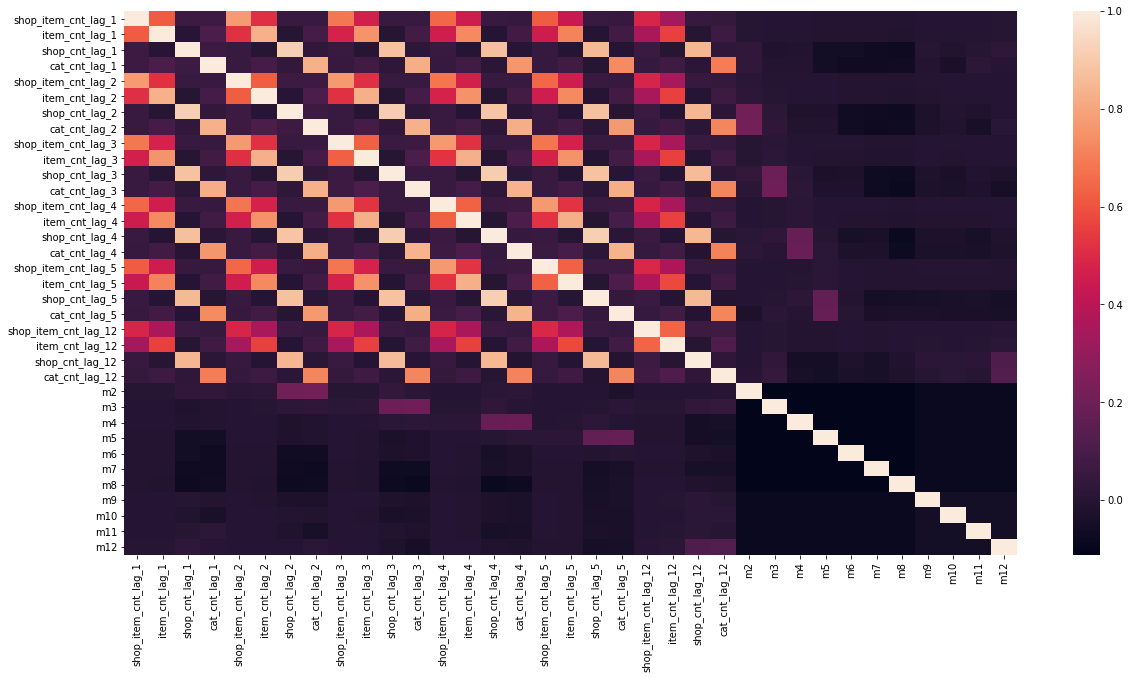

In [48]:
plt.figure(figsize=(20,10))
sns.heatmap(corr)

In [49]:
lm = LinearRegression()

In [50]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [51]:
pred_lm = lm.predict(val[feats])

In [52]:
rmse_clip(y_true = val.loc[val.shop_item_cnt>0,'shop_item_cnt'],y_pred = pred_lm[val.shop_item_cnt>0])

8.20359792163556

In [53]:
gc.collect()

48

In [54]:
%%time
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':7, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

Wall time: 1min 34s


In [55]:
pred_lgb = model.predict(val[feats])
print("Val (32):",rmse_clip(y_true = val.loc[val.shop_item_cnt>0,'shop_item_cnt'],y_pred = pred_lgb[val.shop_item_cnt>0]))

Val (32): 8.233260326001865


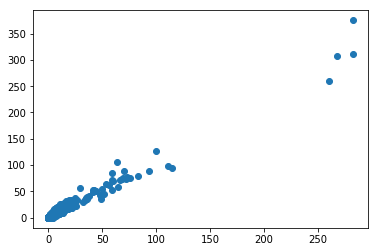

In [56]:
plt.scatter(pred_lgb[val.shop_item_cnt>0],pred_lm[val.shop_item_cnt>0])

([<matplotlib.axis.XTick at 0x1dd827968d0>,
 <a list of 35 Text xticklabel objects>)

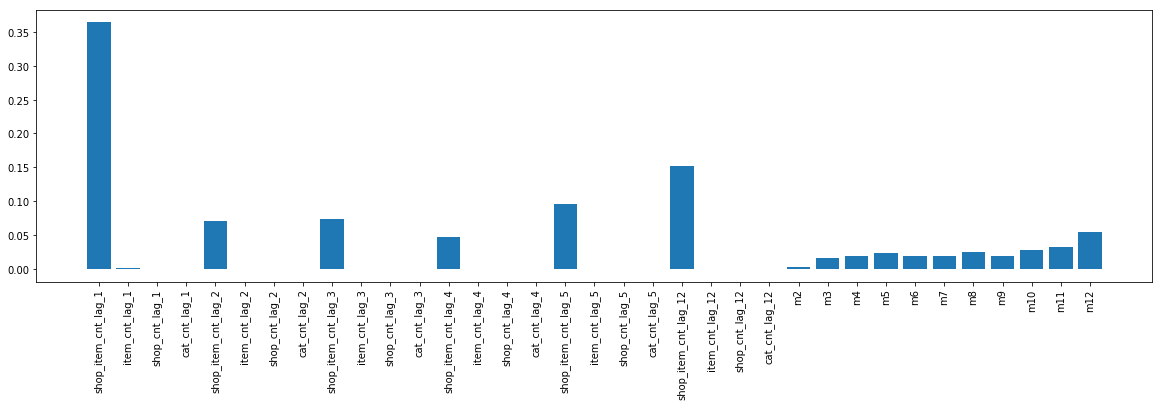

In [50]:
plt.figure(figsize=(20,5))
ticks = list(range(len(lm.coef_)))
plt.bar(ticks,height=lm.coef_)
plt.xticks(ticks,feats,rotation=90)

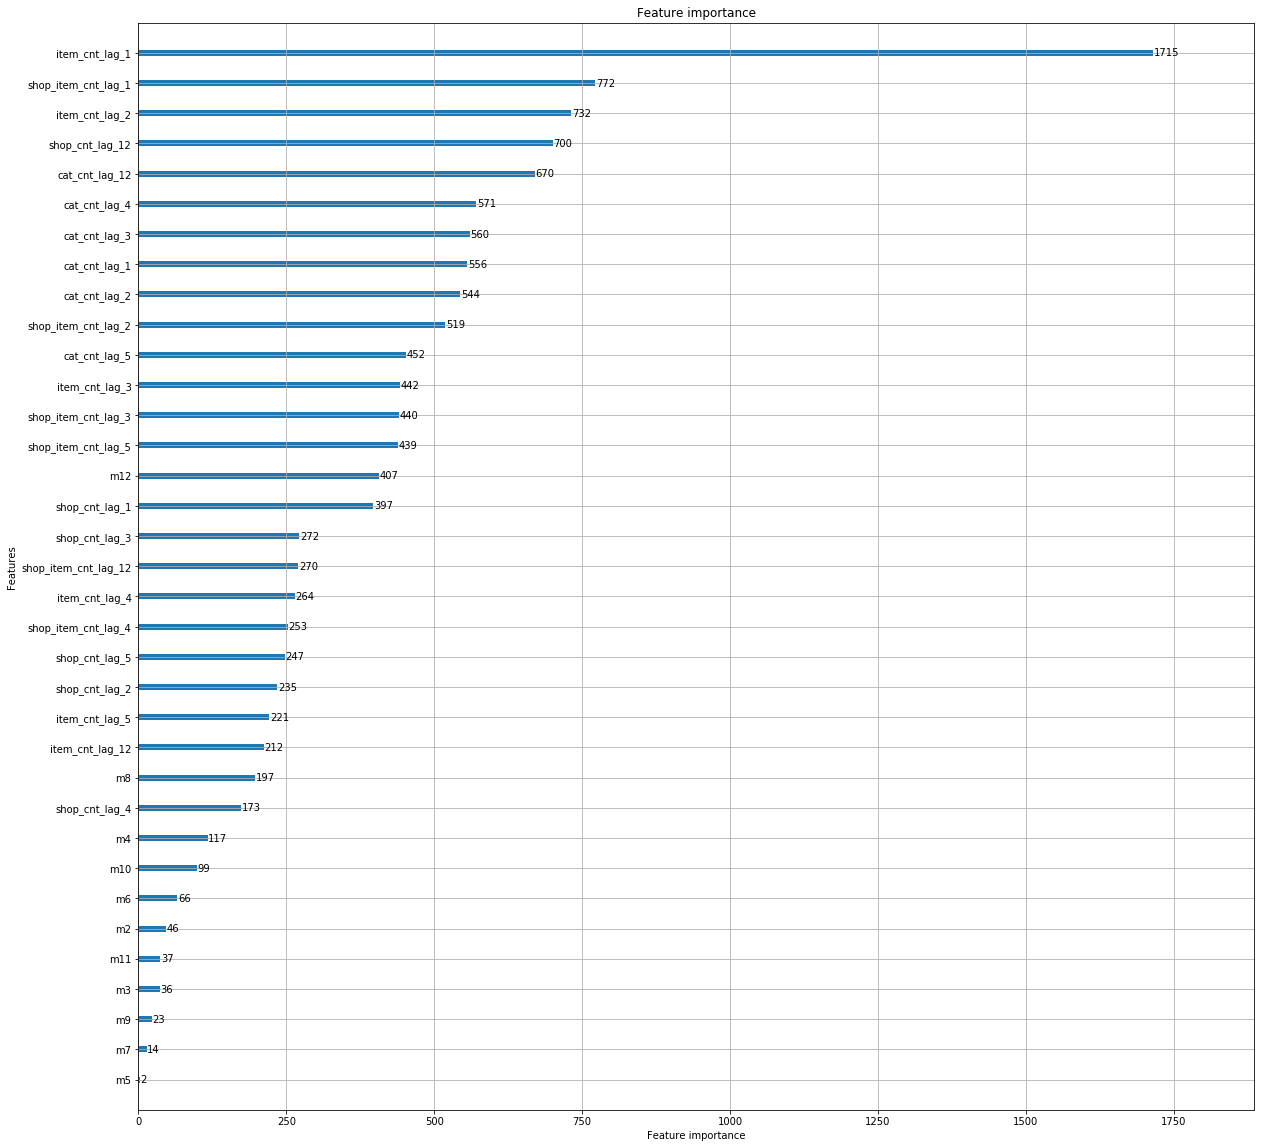

In [57]:
lgb.plot_importance(model,figsize=(20,20))

### Ok, why doesn't score improve???

In [58]:
val['lm_pred'] = pred_lm
val['lgb_pred'] = pred_lgb
val2 = val[val.shop_item_cnt>0]
val2.shape

(29652, 40)

<Figure size 1440x360 with 0 Axes>

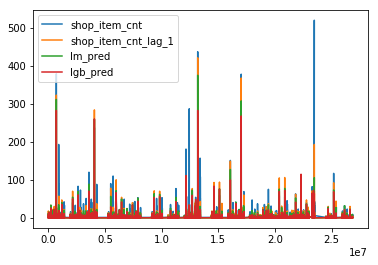

In [59]:
plt.figure(figsize=(20,5))
val2[['shop_item_cnt','shop_item_cnt_lag_1','lm_pred','lgb_pred']].plot()

## Ok there seems to be Extremely high sales of in month 32

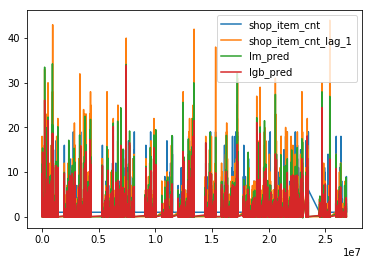

In [60]:
val2.loc[val2.shop_item_cnt<20,['shop_item_cnt','shop_item_cnt_lag_1','lm_pred','lgb_pred']].plot()

In [61]:
for col in ['shop_item_cnt_lag_1','lm_pred','lgb_pred']:
    print(col,rmse_clip(val2.loc[val2.shop_item_cnt<20,'shop_item_cnt'],val2.loc[val2.shop_item_cnt<20,col]))

shop_item_cnt_lag_1 2.2048763591676313
lm_pred 2.0309925796546033
lgb_pred 1.9952929508725705


<strong>Not too bad for the normal range... 

Stacking will work;

Since there is improvement, create a submission w only time-based features </strong>

### Create a new submission

In [62]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/monthly_sales_all_shop_item_w_lag_cat_top3_avg.h5','monthly_sales_all')

Wall time: 47.7 s


In [63]:
monthly_sales_all = monthly_sales_all[(monthly_sales_all.date_block_num>=12) & (monthly_sales_all.date_block_num<34)]

In [64]:
monthly_sales_all = pd.merge(monthly_sales_all,m_onehot_df,how='left',on='month').drop(labels=['month'],axis=1)
monthly_sales_all[:3]

,cat_cnt,date_block_num,item_cnt,item_id,shop_cnt,shop_id,shop_item_cnt,cat_cnt_lag_1,item_cnt_lag_1,shop_cnt_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,190.784729,12,0.0,22154,1500.0,59,0.0,224.190857,1.0,2398.0,...,0,0,0,0,0,0,0,0,0,0
1,213.054642,13,0.0,22154,1428.0,59,0.0,190.784729,0.0,1500.0,...,0,0,0,0,0,0,0,0,0,0
2,141.346558,14,0.0,22154,1475.0,59,0.0,213.054642,0.0,1428.0,...,1,0,0,0,0,0,0,0,0,0


In [65]:
X_train = monthly_sales_all[feats]

In [66]:
y_train = monthly_sales_all['shop_item_cnt']

In [67]:
del monthly_sales_all
gc.collect()

84

In [68]:
%%time
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':7, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

Wall time: 2min 10s


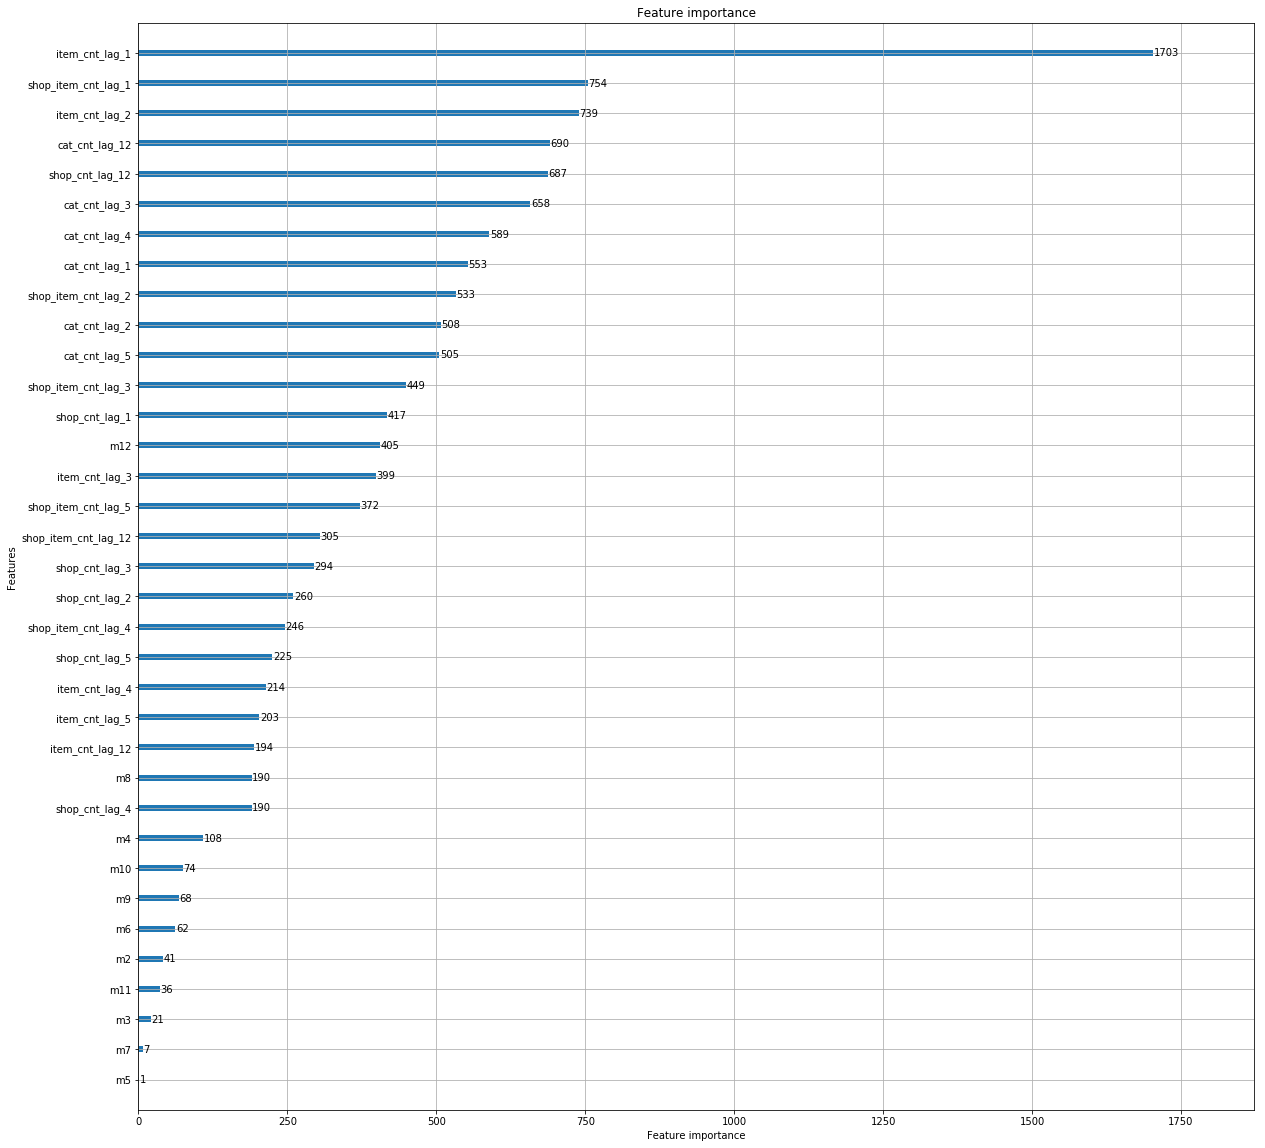

In [69]:
lgb.plot_importance(model,figsize=(20,20))

#### Read in test data and get features

In [70]:
test = pd.read_csv(r'../data/test.csv.gz')
test[:3]

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [71]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/monthly_sales_all_shop_item_w_lag_cat_top3_avg.h5','monthly_sales_all')

Wall time: 48.1 s


In [72]:
monthly_sales_all = monthly_sales_all[monthly_sales_all.date_block_num==34]

In [73]:
gc.collect()

49

In [74]:
monthly_sales_all = pd.merge(monthly_sales_all,m_onehot_df,how='left',on='month')
monthly_sales_all[:3]

,cat_cnt,date_block_num,item_cnt,item_id,shop_cnt,shop_id,shop_item_cnt,cat_cnt_lag_1,item_cnt_lag_1,shop_cnt_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,0.0,34,0.0,22154,0.0,59,0.0,124.611938,5.0,792.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,34,0.0,2552,0.0,59,0.0,31.488197,0.0,792.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,34,0.0,2554,0.0,59,0.0,20.733076,0.0,792.0,...,0,0,0,0,0,0,0,0,1,0


In [75]:
test2 = pd.merge(test,monthly_sales_all,on=['shop_id','item_id'],how='left').fillna(0)
test2.loc[:,'m11'] = 1
print(test2.shape)
test2[:3]

(214200, 44)


,ID,shop_id,item_id,cat_cnt,date_block_num,item_cnt,shop_cnt,shop_item_cnt,cat_cnt_lag_1,item_cnt_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,0,5,5037,0.0,34.0,0.0,0.0,0.0,242.414429,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
2,2,5,5233,0.0,34.0,0.0,0.0,0.0,586.295654,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


In [76]:
test2['item_cnt_month'] = model.predict(test2[feats]).clip(0,20)

In [77]:
test2[['ID','item_cnt_month']].to_csv(r'../output/15_1020_lgb_time_feats_cat_top3_clipX.csv',index=False)